In [1]:
import torch

During training, according to
[27], we segment the entire skeleton sequence into 20 clips
equally, and randomly select one frame from each clip to
have a new sequence of 20 frames. During testing, similar
to [2], we randomly create 5 new sequences in the similar
manner and the mean score is used to predict the class.

In [2]:
x1 = torch.load("x1.pt")

In [3]:
x1.shape

torch.Size([5, 256, 1, 20])

The dimensions of the responses are 256 and each dimension corresponds to one selected joint. We count the times
each joint is selected by SMP. The top five chosen joints are
shown by large blue circles and the rest are shown by small
blue circles.

In [4]:
x1

tensor([[[[1.1144, 0.8959, 0.6892,  ..., 0.9051, 0.8339, 0.7415]],

         [[0.0722, 0.0000, 0.0327,  ..., 0.0907, 0.0746, 0.0411]],

         [[0.1711, 0.5537, 0.1164,  ..., 0.9266, 0.0173, 0.0080]],

         ...,

         [[1.2805, 0.3394, 1.9115,  ..., 1.1313, 0.6290, 2.0568]],

         [[1.1134, 0.7703, 0.7962,  ..., 1.0890, 0.4425, 0.5015]],

         [[2.2379, 2.0321, 2.6541,  ..., 2.3020, 2.0789, 1.7311]]],


        [[[0.7678, 0.8355, 0.6892,  ..., 0.6860, 0.7976, 0.8725]],

         [[0.0722, 0.0000, 0.0327,  ..., 0.0907, 0.0746, 0.0411]],

         [[0.1711, 0.0299, 0.1164,  ..., 0.2400, 0.0173, 0.4483]],

         ...,

         [[0.9736, 0.8005, 1.9115,  ..., 1.0945, 1.1977, 1.3733]],

         [[0.9559, 0.9280, 0.7962,  ..., 0.9018, 0.6662, 1.0053]],

         [[2.0009, 1.9918, 2.6541,  ..., 1.6354, 1.5832, 2.2165]]],


        [[[0.7678, 0.8355, 0.6892,  ..., 0.7272, 0.7976, 0.7228]],

         [[0.0722, 0.0000, 0.0327,  ..., 0.0907, 0.0746, 0.0411]],

         [[0.1

In [5]:
x1_pre_smp = torch.load("x1_pre_smp.pt")

In [6]:
x1_pre_smp.shape

torch.Size([5, 256, 29, 20])

In [7]:
def analyze_smp_selections(input_tensor, pooled_tensor, num_joints=29):
    # input_tensor shape: [5, 256, 29, 20]
    # pooled_tensor shape: [5, 256, 1, 20]
    
    joint_counts = torch.zeros(num_joints)
    
    # Let's look at a few examples first
    seq = 0
    frame = 0
    channel = 0
    
    # Print some debug information
    print(f"Input shape: {input_tensor.shape}")
    print(f"Pooled shape: {pooled_tensor.shape}")
    
    # Look at one specific example
    values = input_tensor[seq, channel, :, frame]
    selected_joint = torch.argmax(values)
    max_value = values[selected_joint]
    pooled_value = pooled_tensor[seq, channel, 0, frame]
    
    print(f"\nExample values for seq={seq}, channel={channel}, frame={frame}:")
    print(f"All joint values:\n{values}")
    print(f"Selected joint: {selected_joint}")
    print(f"Max value: {max_value}")
    print(f"Pooled value: {pooled_value}")
    
    # Maybe there's some preprocessing or normalization happening?
    print(f"\nValue ranges:")
    print(f"Input tensor range: [{input_tensor.min():.4f}, {input_tensor.max():.4f}]")
    print(f"Pooled tensor range: [{pooled_tensor.min():.4f}, {pooled_tensor.max():.4f}]")
    
    return joint_counts

# Call the function with your tensors
joint_selections = analyze_smp_selections(x1_pre_smp, x1)

Input shape: torch.Size([5, 256, 29, 20])
Pooled shape: torch.Size([5, 256, 1, 20])

Example values for seq=0, channel=0, frame=0:
All joint values:
tensor([0.0345, 0.2065, 0.4226, 0.1417, 0.0345, 0.5126, 0.2923, 0.0937, 0.6356,
        0.7513, 0.0715, 0.8383, 1.1144, 0.5472, 0.6856, 0.6812, 0.0345, 0.0345,
        0.2694, 0.0345, 0.0345, 0.9125, 0.6267, 0.5556, 0.5361, 0.2014, 0.0345,
        0.4330, 0.1991], device='cuda:0')
Selected joint: 12
Max value: 1.1143769025802612
Pooled value: 1.1143769025802612

Value ranges:
Input tensor range: [0.0000, 3.9937]
Pooled tensor range: [0.0000, 3.9937]


In [8]:
import torch.nn as nn

def analyze_smp_selections(input_tensor, pooled_tensor, num_joints=29):
    # Create the pooling layer
    pool = nn.AdaptiveMaxPool2d((1, 20))
    
    # Try pooling directly
    our_pooled = pool(input_tensor)
    
    print("Comparing our pooling with provided pooled tensor:")
    print(f"Our pooled shape: {our_pooled.shape}")
    print(f"Given pooled shape: {pooled_tensor.shape}")
    
    # Check if they're the same
    print("\nFirst few values:")
    print(f"Our pooled: {our_pooled[0, 0, 0, 0]:.4f}")
    print(f"Given pooled: {pooled_tensor[0, 0, 0, 0]:.4f}")
    
    # Check if there's any consistent relationship
    ratio = pooled_tensor / our_pooled
    print(f"\nRatio between given and our pooling (first few values):")
    print(ratio[0, 0, 0, :5])
    
    # Are they proportional?
    is_constant_ratio = torch.allclose(ratio, ratio[0,0,0,0], rtol=1e-3)
    print(f"\nIs there a constant ratio? {is_constant_ratio}")
    if is_constant_ratio:
        print(f"Constant ratio value: {ratio[0,0,0,0]:.4f}")

    return our_pooled, ratio

# Try this analysis
our_pooled, ratio = analyze_smp_selections(x1_pre_smp, x1)

Comparing our pooling with provided pooled tensor:
Our pooled shape: torch.Size([5, 256, 1, 20])
Given pooled shape: torch.Size([5, 256, 1, 20])

First few values:
Our pooled: 1.1144
Given pooled: 1.1144

Ratio between given and our pooling (first few values):
tensor([1., 1., 1., 1., 1.], device='cuda:0')

Is there a constant ratio? False


In [9]:
def analyze_smp_selections(input_tensor, pooled_tensor, num_joints=29):
    # input_tensor shape: [5, 256, 29, 20]
    # pooled_tensor shape: [5, 256, 1, 20]
    
    joint_counts = torch.zeros(num_joints)
    
    # Iterate through all dimensions
    for seq in range(5):
        for frame in range(20):
            for channel in range(256):
                # Get the values for this channel and frame across all joints
                values = input_tensor[seq, channel, :, frame]
                
                # Find which joint had the maximum value
                selected_joint = torch.argmax(values)
                max_value = values[selected_joint]
                
                # Verify this is correct by checking against pooled result
                pooled_value = pooled_tensor[seq, channel, 0, frame]
                assert torch.isclose(max_value, pooled_value, rtol=1e-5), \
                    f"Max value {max_value} doesn't match pooled value {pooled_value}"
                
                # Increment count for this joint
                joint_counts[selected_joint] += 1

    return joint_counts

# Assuming you have both tensors:
# original_tensor: the input to SMP
# pooled_tensor: the output from SMP
joint_selections = analyze_smp_selections(x1_pre_smp, x1)

# Get the most selected joints
top_5_values, top_5_indices = torch.topk(joint_selections, 5)
print("\nTop 5 most selected joints:")
for idx, value in zip(top_5_indices, top_5_values):
    print(f"Joint {idx}: {value.item()} selections")

# Calculate percentage of times each joint was selected
total_selections = 5 * 256 * 20  # sequences * channels * frames
percentages = (joint_selections / total_selections) * 100

print("\nSelection percentages:")
for joint in range(29):
    print(f"Joint {joint}: {percentages[joint]:.2f}%")


Top 5 most selected joints:
Joint 0: 4599.0 selections
Joint 26: 3134.0 selections
Joint 28: 1300.0 selections
Joint 4: 1181.0 selections
Joint 23: 1118.0 selections

Selection percentages:
Joint 0: 17.96%
Joint 1: 0.87%
Joint 2: 4.04%
Joint 3: 3.89%
Joint 4: 4.61%
Joint 5: 2.36%
Joint 6: 1.21%
Joint 7: 2.32%
Joint 8: 4.21%
Joint 9: 2.14%
Joint 10: 1.39%
Joint 11: 1.07%
Joint 12: 2.60%
Joint 13: 2.57%
Joint 14: 2.41%
Joint 15: 0.61%
Joint 16: 4.07%
Joint 17: 3.70%
Joint 18: 0.55%
Joint 19: 2.66%
Joint 20: 1.79%
Joint 21: 1.85%
Joint 22: 1.27%
Joint 23: 4.37%
Joint 24: 4.35%
Joint 25: 2.46%
Joint 26: 12.24%
Joint 27: 1.35%
Joint 28: 5.08%


c:\Users\LouieMiddle\Documents\Data Science\Football\SimpleGCN\.venv\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


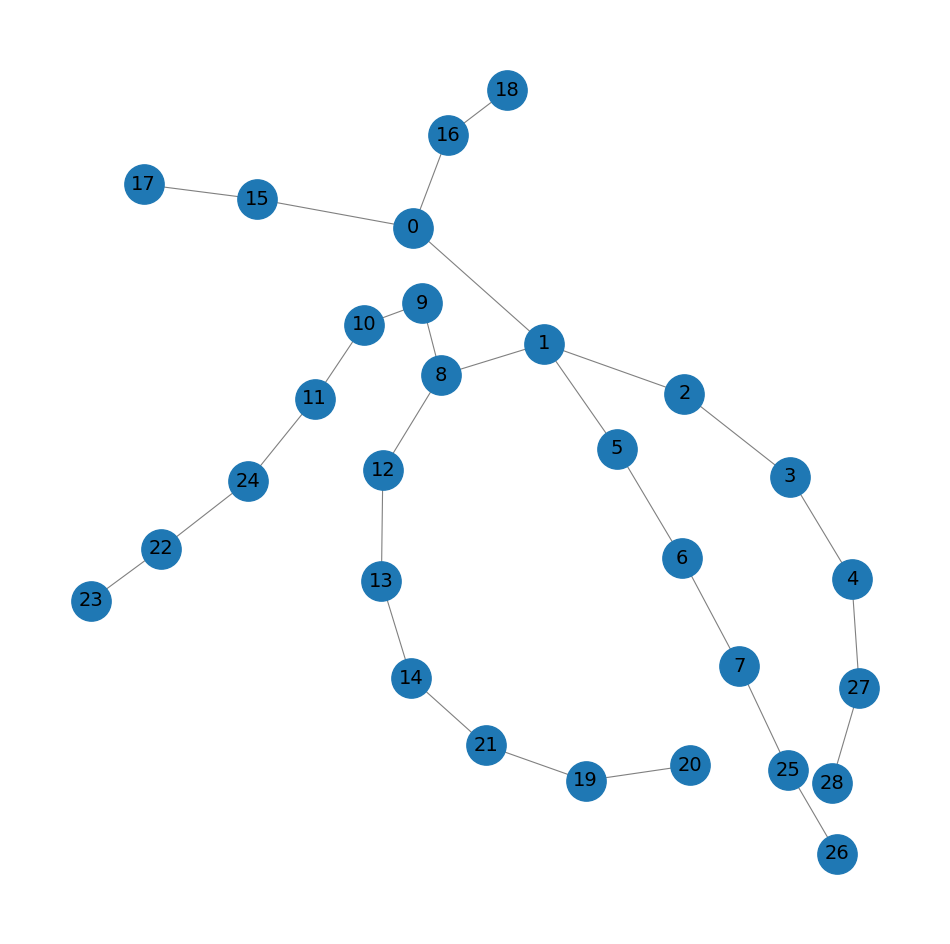

In [10]:
import networkx as nx

from matplotlib import pyplot as plt
from util.graph import football_graph, draw_graph

def get_skeleton_layout():
    # Define positions based on the actual skeleton structure
    pos = {
        # Head
        0: (0, 1.0),     # Nose
        15: (0.1, 1.1),  # Right Eye
        16: (-0.1, 1.1), # Left Eye
        17: (0.2, 1.0),  # Right Ear
        18: (-0.2, 1.0), # Left Ear
        
        # Upper body
        1: (0, 0.8),     # Neck
        2: (0.3, 0.7),   # Right Shoulder
        3: (0.4, 0.5),   # Right Elbow
        4: (0.5, 0.3),   # Right Wrist
        5: (-0.3, 0.7),  # Left Shoulder
        6: (-0.4, 0.5),  # Left Elbow
        7: (-0.5, 0.3),  # Left Wrist
        
        # Hands
        27: (0.6, 0.2),  # Right Thumb
        28: (0.5, 0.1),  # Right Pinky
        25: (-0.6, 0.2), # Left Thumb
        26: (-0.5, 0.1), # Left Pinky
        
        # Center
        8: (0, 0.4),     # Mid Hip
        
        # Right leg
        9: (0.2, 0.3),   # Right Hip
        10: (0.2, 0),    # Right Knee
        11: (0.2, -0.3), # Right Ankle
        22: (0.1, -0.5), # Right Big Toe
        23: (0.3, -0.5), # Right Small Toe
        24: (0.2, -0.4), # Right Heel
        
        # Left leg
        12: (-0.2, 0.3), # Left Hip
        13: (-0.2, 0),   # Left Knee
        14: (-0.2, -0.3),# Left Ankle
        19: (-0.1, -0.5),# Left Big Toe
        20: (-0.3, -0.5),# Left Small Toe
        21: (-0.2, -0.4) # Left Heel
    }
    return pos

def visualize_joint_importance(G, joint_selections):
    if torch.is_tensor(joint_selections):
        joint_selections = joint_selections.cpu().numpy()
    
    normalized_selections = (joint_selections - joint_selections.min()) / \
                          (joint_selections.max() - joint_selections.min())
    
    plt.figure(figsize=(10, 15))  # Made taller to better show full body
    
    pos = get_skeleton_layout()
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, 
                          edgelist=list(G.edges()), 
                          edge_color='gray', 
                          alpha=0.5,
                          width=2)
    
    # Draw nodes
    node_sizes = []
    node_colors = []
    top_5_indices = set(torch.topk(torch.tensor(joint_selections), 5).indices.cpu().numpy())
    
    for node in G.nodes():
        if node in top_5_indices:
            node_sizes.append(3000 * normalized_selections[node])
            node_colors.append('#1f77b4')  # darker blue
        else:
            node_sizes.append(1500 * normalized_selections[node])
            node_colors.append('#a6cee3')  # lighter blue
    
    nx.draw_networkx_nodes(G, pos, 
                          nodelist=list(G.nodes()),
                          node_size=node_sizes,
                          node_color=node_colors)
    
    # Add labels with smaller font
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.title("Joint Selection Frequency in SMP\n" + 
             "Top 5 joints (darker blue): " + 
             ", ".join([f"{i} ({['Nose', 'Neck', 'R.Shoulder', 'R.Elbow', 'R.Wrist', 'L.Shoulder', 'L.Elbow', 'L.Wrist', 'M.Hip', 'R.Hip', 'R.Knee', 'R.Ankle', 'L.Hip', 'L.Knee', 'L.Ankle', 'R.Eye', 'L.Eye', 'R.Ear', 'L.Ear', 'L.BigToe', 'L.SmallToe', 'L.Heel', 'R.BigToe', 'R.SmallToe', 'R.Heel', 'L.Thumb', 'L.Pinky', 'R.Thumb', 'R.Pinky'][i]})" for i in top_5_indices]))
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

graph = football_graph()

draw_graph(graph)

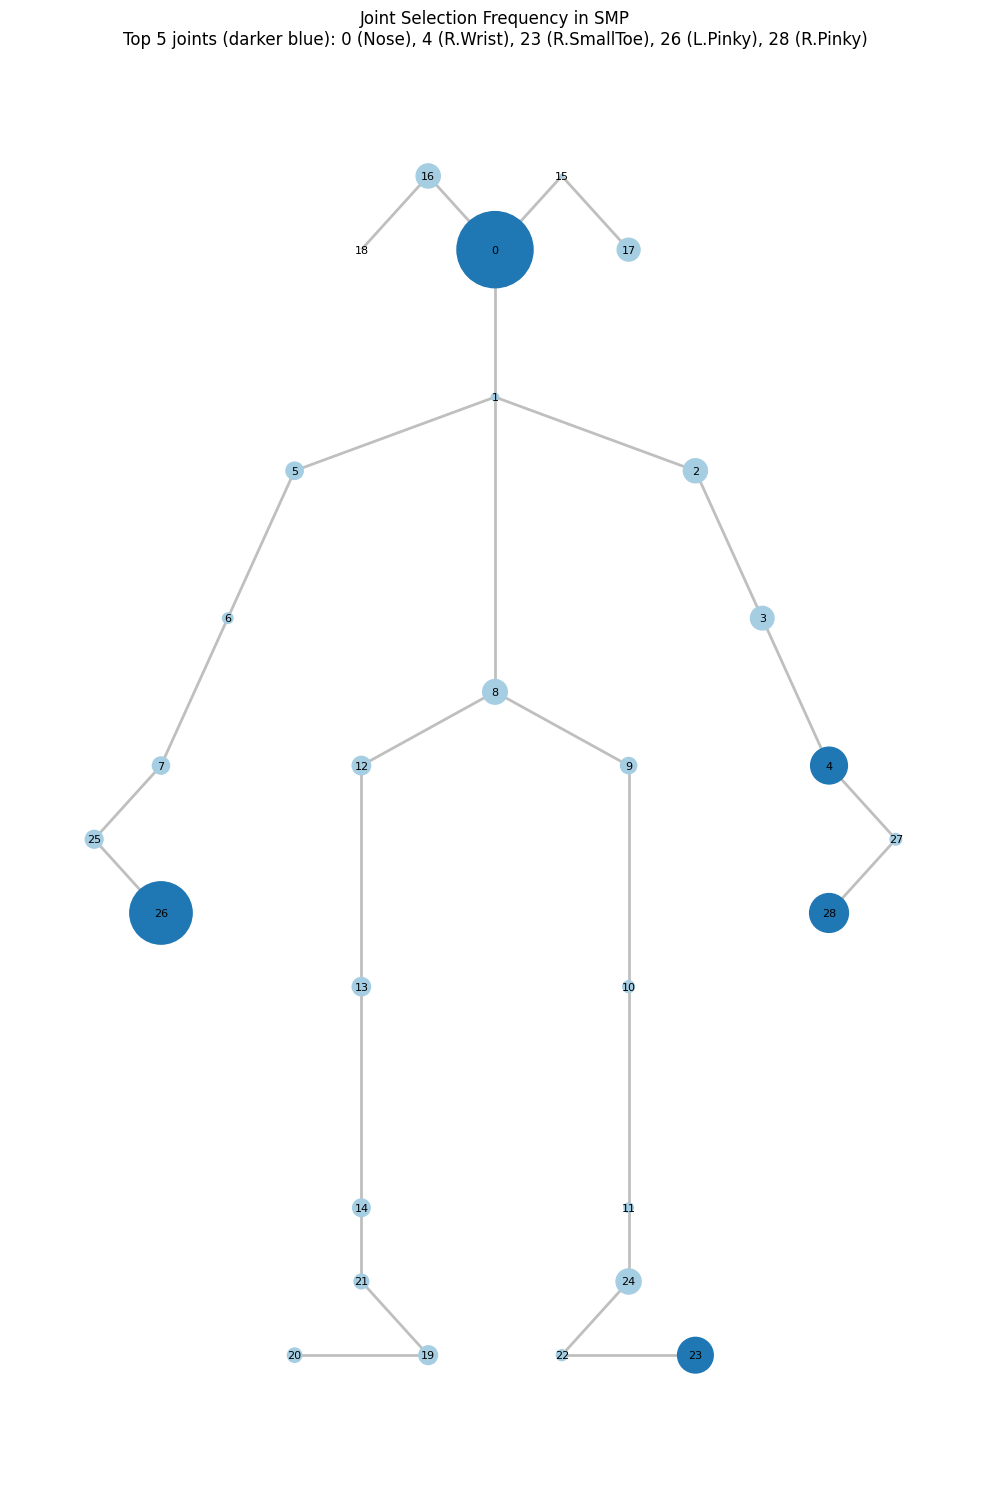

In [11]:
visualize_joint_importance(graph, joint_selections)

In [ ]:
# TODO: Plot this across an entire prediction (animate it)